# L0DeNNS STDP Algorithm
Written by: Akwasi Akwaboah <br>
Date: April 29, 2022 <br>
Description: A demonstrated of the LoDeNNS STDP algorithm is presented. Here, a dimensionality reduction feature extraction is performed. Spatiotemporal --> spatial encoding temporal dynamics. This is shown an eastward and westward horizontal scans.

*A. D. Akwaboah and R. Etienne-Cummings, “Lo-denns: A linearly-approximated and optimized dendrocentric nearest neighbor
stdp(accepted),” in International Conference on Neuromorphic Systems 2022, 2022*

In [1]:
# Simplified
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import transforms

import numpy.matlib
import os

Spatiotemporal Pattern Generation (Eastward and Westward propagating vertical scans)

In [2]:
n_steps = 30
ydim = 30
xdim = n_steps
n_inputs = ydim*xdim
Data_fscan = np.zeros((ydim, xdim, n_steps))
Data_rscan = np.zeros((ydim, xdim, n_steps))
for i in range(n_steps):
    Data_fscan[:,i,i] = 1
    Data_rscan[:,-(i+1),i] = 1
    # Data_rscan[i,:,i] = 1

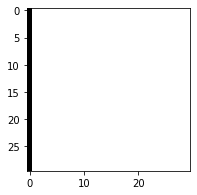

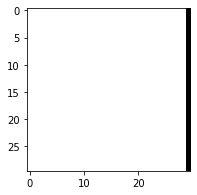

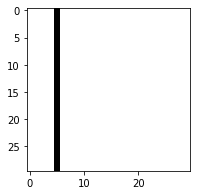

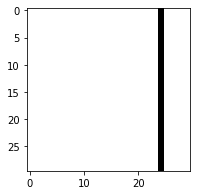

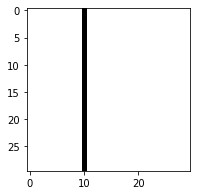

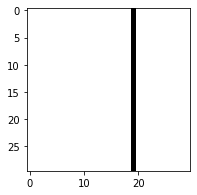

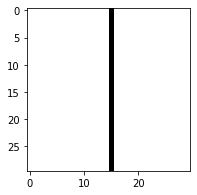

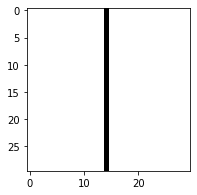

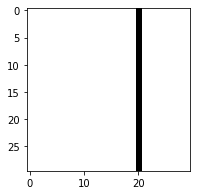

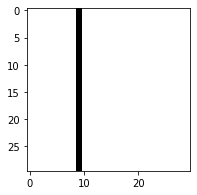

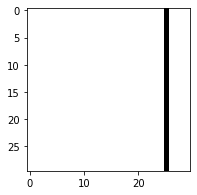

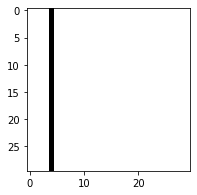

In [3]:
for i in np.arange(0,30,5):
    plt.figure(figsize=(3,3))
    plt.imshow(Data_fscan[:,:,i], cmap='Greys')
    plt.savefig('PA_Eastward %d.png' %i, dpi=1000)
    
    plt.figure(figsize=(3,3))
    plt.imshow(Data_rscan[:,:,i], cmap='Greys')
    plt.savefig('PB_Westward %d.png' %i, dpi=1000)

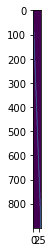

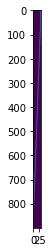

In [4]:
Data_f_rs = np.reshape(Data_fscan, (n_inputs, n_steps), order='F')
Data_r_rs = np.reshape(Data_rscan, (n_inputs, n_steps), order='F')
plt.figure()
plt.imshow(Data_f_rs)
plt.show()
plt.figure()
plt.imshow(Data_r_rs)
plt.show()

Function declarations

In [5]:
def gen_nn_stdp_fn(E_pre, E_post, delta_w, n_i, n_pre1, n_pre2, v, w, A_p, A_m, eta_p, eta_m, w_o):
    # eta_p = 16
    # eta_m = 32
    k = 1
    eta_minus_ak = eta_m*(k+1)
    eta_plus_ak  = eta_p*(k+1)
    eta_pm_x_2 = eta_minus_ak + eta_plus_ak
    
    if E_post == 1:
        if E_pre == 1:
            delta_w = 0
        else:      
            acausal = A_m/eta_m * (eta_minus_ak - n_pre1)*v[0]
            causal = A_p/eta_p * (eta_plus_ak + (n_pre2 - n_i))*v[1]
            if n_pre1 == 0:
                acausal=0
            if n_pre2 == 0:
                causal = 0
            delta_w = acausal + causal
            delta_w = np.exp(-k) * delta_w
            
        n_i = 1
        n_pre1 = 0
        n_pre2 = 0
        v = [0, 0] #tuple used here, equivalent to matlab cell
    else:
        # delta_w = 0 #delta_w_reg
        if n_i == 0: #Primus Spike
            n_i = 0
            n_pre1 = 0
            n_pre2 = 0
            v = [0, 0]
        else:
            if n_i == eta_pm_x_2:
                if E_pre == 1:
                    n_i = n_i + 1
                else:
                    n_i = eta_pm_x_2
            elif n_i > (eta_pm_x_2 + eta_plus_ak):
                n_i = eta_pm_x_2
            elif (n_i > eta_pm_x_2) and E_pre == 1:
                n_i = eta_pm_x_2 + 1 #rollover reset in the absence of terminating postsynaptic spike
            else:
                n_i = n_i + 1

         # ----- Flags --------
            if E_pre == 1:
                n_pre2 = n_i
                #causal spike pairing flag
                if n_i > (n_i - eta_plus_ak): #here ni = npre2
                    v[1] = 1 #v1
                else:
                    v[1] = 0
                if n_pre1 == 0: #if still unchanged from lower bound
                    n_pre1 = n_i
                    # acausal spike pairing flag
                    if n_i <= eta_minus_ak: #here n_i_reg = n_pre1
                        v[0] = 1 #v0
                    else:
                        v[0] = 0
            else:
                # background acausal spike pairing flag
                if n_pre1 <= eta_minus_ak: #here n_i_reg = n_pre1
                    v[0] = 1 #v0
                else:
                  #n_pre1 = 0
                    v[0] = 0

                #background causal pairing flag
                if n_pre2 > n_i - eta_plus_ak: #here ti = tpre2
                    v[1] = 1
                else:
                    n_pre2 = 0;
                    v[1] = 0
                
    w = w + w*(delta_w)*E_post # only update on postsynaptic event
    # v = tuple(v)
#     w_max = w_o + 2*w_o
#     w_min = w_o - 2*w_o
    
#     if w > w_max:
#         w = w_max
#     elif w < w_min:
#         w = w_min  
    
    return w, delta_w, n_i, n_pre1, n_pre2, v


def LIF_neuron(Vm_i, events_i, nW_syn, t_ref_i, cache_events_i):
    dt = 1e-3
    EL = 0.0
    Cm = 30e-9
    Rm = 1e6
    tau_m = Rm*Cm
    V_thr = 0.01#0.0142
    I_e = 1.5e-9

    Gsyn_o = event_kernel(cache_events_i)
    if t_ref_i <= 4*dt:
        t_ref_o = t_ref_i + dt
        Vm_o = EL
        event_o = 0
    elif Vm_i < V_thr:
         # dVm = ((events_i'*nW_syn)*I_e/Cm - (Vm_i - EL)/tau_m)*dt;
        dVm = ((nW_syn@Gsyn_o)/Cm - (Vm_i - EL)/tau_m)*dt
        Vm_o = Vm_i + dVm
        event_o = 0
        t_ref_o = 5*dt
    else:
        Vm_o = EL
        event_o = 1
        t_ref_o = 0
                     
    return event_o, Vm_o, t_ref_o

def intra_knl_worker(cache_events_i):
    dt = 1e-3
    tau_s = 5e-3
    if sum(cache_events_i) != 0:
        etimes = np.where(cache_events_i == 1.0)[0]
        if len(etimes) != 0:
            knl_o = (np.exp(1.0)/tau_s) * sum(dt * etimes * np.exp(-(dt/tau_s)*etimes))
        else:
            knl_o = 0
    else:
            knl_o = 0
    return knl_o

def event_kernel(cache_events_i):
    dt = 1e-3
    tau_s = 5e-3
    b = cache_events_i.shape[0] #no of inputs/synapses
    knl_o = np.zeros(b)

    for i in range(b):
        if sum(cache_events_i[i,:]) != 0:
            etimes = np.where(cache_events_i[i,:] == 1.0)[0]
            if len(etimes) != 0:
                knl_o[i] = (np.exp(1.0)/tau_s) * sum(dt * etimes * np.exp(-(dt/tau_s)*etimes))
            else:
                
                knl_o[i] = 0
        else:
            knl_o[i] = 0
    return knl_o
            
# def event_kernel(cache_events_i):
#     dt = 1e-3
#     tau_s = 5e-3
#     b = cache_events_i.shape[0] #no of inputs/synapses
#     knl_o = np.zeros(b)
#     p = mp.Pool(processes=8)
#     p.map(cache_events_i)

#     for i in range(b):
#         if sum(cache_events_i[i,:]) != 0:
#             etimes = np.where(cache_events_i[i,:] == 1.0)[0]
#             if len(etimes) != 0:
#                 knl_o[i] = (np.exp(1.0)/tau_s) * sum(dt * etimes * np.exp(-(dt/tau_s)*etimes))
#             else:
                
#                 knl_o[i] = 0
#         else:
#             knl_o[i] = 0
#     return knl_o

def b_arr2dec(x):
    y = x[0]*2 + x[1]
    return y

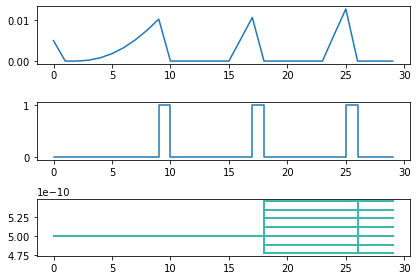

In [6]:
# frame_vec_sm = parse_data('Data/Test/0/00004.bin')
frame_vec_sm = Data_f_rs

n_inputs = frame_vec_sm.shape[0] #inputs
n_steps = frame_vec_sm.shape[1]

t = np.arange(n_steps)
w_o = 1e-7
A_p = 1
A_m = -1
eta_p = 32
eta_m = 32

w = np.zeros(n_steps)
delta_w = np.zeros((n_inputs, n_steps))
n_i = np.zeros((n_inputs, n_steps))
n_pre1 = np.zeros((n_inputs, n_steps))
n_pre2 = np.zeros((n_inputs, n_steps))
v = np.zeros((n_inputs,2,n_steps))
cache_size = 50;
inputs_cache_i = np.zeros((n_inputs, 50))
output_cache_o = np.zeros((n_inputs, 50))
event_i = np.zeros((n_inputs, n_steps))
Vm_i = np.zeros((n_inputs, n_steps))
event_o = np.zeros(n_steps)
Vm_o = np.zeros(n_steps)
Vm_o[0] = 0.005
nW_syn_f = np.ones((n_inputs, n_steps))*0.5e-9
t_ref_i = np.ones(n_inputs)*5e-3
t_ref_o = 5e-3

for i in np.arange(2, n_steps):
    # w[i], delta_w[i], n_i[i], n_pre1[i], n_pre2[i], v[:,i] = \
    #     nn_stdp_fn(E_pre[i-1], E_post[i-1], delta_w[i-1], n_i[i-1], n_pre1[i-1], n_pre2[i-1], v[:,i-1], w[i-1])
    if i%1000 == 0:
        print(i/316 *100, '%')
    for j in range(n_inputs):
        nW_syn_f[j,i], delta_w[j,i], n_i[j,i], n_pre1[j,i], n_pre2[j,i], v[j,:,i] = \
            gen_nn_stdp_fn(frame_vec_sm[j,i], event_o[i-1], delta_w[j, i-1], n_i[j, i-1], n_pre1[j, i-1], n_pre2[j, i-1], v[j, :,i-1], nW_syn_f[j, i-1]\
                      ,A_p, A_m, eta_p, eta_m, w_o)
    output_cache_o[:,1:] = output_cache_o[:,:-1]
    output_cache_o[:,0] = frame_vec_sm[:,i]
    # print(output_cache_o)
    event_o[i], Vm_o[i], t_ref_o = LIF_neuron(Vm_o[i-1], event_o[i-1], nW_syn_f[:,i-1], t_ref_o, output_cache_o)
    
v_ = [b_arr2dec(v[0,:,i]) for i in range(n_steps)]

n_rows = 3
plt.figure()
plt.subplot(n_rows,1,1)
plt.plot(t, Vm_o)
plt.subplot(n_rows,1,2)
plt.step(t, event_o)
plt.subplot(n_rows,1,3)
plt.step(t, nW_syn_f.T)
plt.tight_layout()
plt.show()

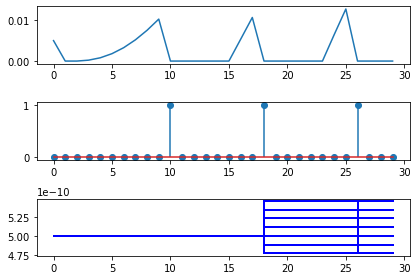

In [7]:
# frame_vec_sm = parse_data('Data/Test/0/00004.bin')
frame_vec_sm = Data_r_rs

n_inputs = frame_vec_sm.shape[0] #inputs
n_steps = frame_vec_sm.shape[1]

t = np.arange(n_steps)


w = np.zeros(n_steps)
delta_w = np.zeros((n_inputs, n_steps))
n_i = np.zeros((n_inputs, n_steps))
n_pre1 = np.zeros((n_inputs, n_steps))
n_pre2 = np.zeros((n_inputs, n_steps))
v = np.zeros((n_inputs,2,n_steps))
cache_size = 50;
inputs_cache_i = np.zeros((n_inputs, 50))
output_cache_o = np.zeros((n_inputs, 50))
event_i = np.zeros((n_inputs, n_steps))
Vm_i = np.zeros((n_inputs, n_steps))
event_o = np.zeros(n_steps)
Vm_o = np.zeros(n_steps)
Vm_o[0] = 0.005
nW_syn_r = np.ones((n_inputs, n_steps))*0.5e-9
t_ref_i = np.ones(n_inputs)*5e-3
t_ref_o = 5e-3

for i in np.arange(2, n_steps):
    # w[i], delta_w[i], n_i[i], n_pre1[i], n_pre2[i], v[:,i] = \
    #     nn_stdp_fn(E_pre[i-1], E_post[i-1], delta_w[i-1], n_i[i-1], n_pre1[i-1], n_pre2[i-1], v[:,i-1], w[i-1])
    if i%1000 == 0:
        print(i/316 *100, '%')
    for j in range(n_inputs):
        nW_syn_r[j,i], delta_w[j,i], n_i[j,i], n_pre1[j,i], n_pre2[j,i], v[j,:,i] = \
            gen_nn_stdp_fn(frame_vec_sm[j,i], event_o[i-1], delta_w[j, i-1], n_i[j, i-1], n_pre1[j, i-1], n_pre2[j, i-1], v[j, :,i-1], nW_syn_r[j, i-1] \
                       ,A_p, A_m, eta_p, eta_m, w_o)
    output_cache_o[:,1:] = output_cache_o[:,:-1]
    output_cache_o[:,0] = frame_vec_sm[:,i]
    # print(output_cache_o)
    event_o[i], Vm_o[i], t_ref_o = LIF_neuron(Vm_o[i-1], event_o[i-1], nW_syn_r[:,i-1], t_ref_o, output_cache_o)
    
v_ = [b_arr2dec(v[0,:,i]) for i in range(n_steps)]

n_rows = 3
plt.figure()
plt.subplot(n_rows,1,1)
plt.plot(t, Vm_o)
plt.subplot(n_rows,1,2)
plt.stem(t, event_o)
plt.subplot(n_rows,1,3)
# plt.step(t, nW_syn_f.T, '-r')
plt.step(t, nW_syn_r.T, '-b')
plt.tight_layout()
plt.show()

Spatial Features (synaptic weights) encoding time

<function matplotlib.pyplot.show(close=None, block=None)>

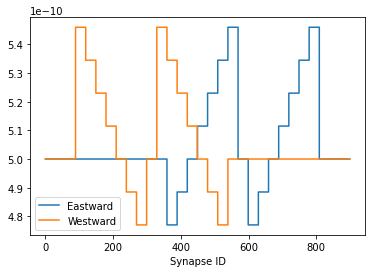

In [8]:
plt.figure()
plt.step(np.arange(n_inputs), nW_syn_f[:,-1])
plt.step(np.arange(n_inputs), nW_syn_r[:,-1])
plt.xlabel("Synapse ID")
plt.legend(["Eastward", "Westward"])
plt.show

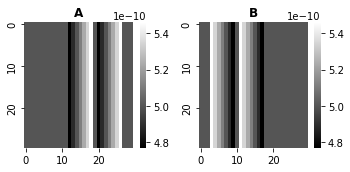

In [9]:
import seaborn as sns
plt.figure(figsize=(5,2.5))
a = np.reshape(nW_syn_f[:,-1], (ydim,xdim), 'F')

t_steps = 10
# plt.colorbar()
b = np.reshape(nW_syn_r[:,-1], (ydim,xdim), 'F')
plt.subplot(1,2,1)
sns.heatmap(a, xticklabels=t_steps, yticklabels=t_steps, cmap='gray')
plt.title('A',fontweight="bold")
plt.subplot(1,2,2)
plt.title('B',fontweight="bold")
sns.heatmap(b, xticklabels=t_steps, yticklabels=t_steps, cmap='gray')
plt.tight_layout()
plt.savefig('Sequence.png', dpi=1000)
print("Synaptic Weights resized to match instantaneous input dimensions")
print("A: Eastward moving horizontal scan")
print("B: Westward moving horizontal scan")